# Covertype

In [48]:
%load_ext autoreload
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from jax import config
config.update("jax_debug_nans", False)
from tqdm import tqdm
from jax import config


import jax.numpy as jnp
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
import scipy
import haiku as hk
    
import utils
import plot
import distributions
import stein
import models
import flows
from itertools import cycle, islice

key = random.PRNGKey(0)

from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

from functools import partial
import kernels
import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import optax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [49]:
data = scipy.io.loadmat('/home/lauro/code/msc-thesis/wang_svgd/data/covertype.mat')
features = data['covtype'][:, 1:]
features = onp.hstack([features, onp.ones([features.shape[0], 1])]) # add intercept term

labels = data['covtype'][:, 0]
labels[labels == 2] = 0

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

num_features = features.shape[-1]

In [145]:
batch_size = 128
num_datapoints = len(x_train)
num_batches = num_datapoints // batch_size


def get_batches(x, y, n_steps=num_batches*2, batch_size=batch_size):
    """Split x and y into batches"""
    assert len(x) == len(y)
    assert x.ndim > y.ndim
    n = len(x)
    idxs = onp.random.choice(n, size=(n_steps, batch_size))
    for idx in idxs:
        yield x[idx], y[idx]
#     batch_cycle = cycle(zip(*[onp.array_split(data, len(data)//batch_size) for data in (x, y)]))
#     return islice(batch_cycle, n_steps)

# Model

In [146]:
a0, b0 = 1, 0.01 # hyper-parameters

In [147]:
from jax.scipy import stats, special

In [148]:
# alternative model
@partial(jit, static_argnums=1)
def sample_from_prior(key, num=100):
    keya, keyb = random.split(key)
    alpha = random.gamma(keya, a0, shape=(num,)) / b0
    w = random.normal(keyb, shape=(num, num_features))
    return w, np.log(alpha)


def prior_logp(w, log_alpha):
    """
    Returns logp(w, log_alpha) = sum_i(logp(wi, alphai))

    w has shape (num_features,), or (n, num_features)
    similarly, log_alpha may have shape () or (n,)"""
    if log_alpha.ndim == 0:
        assert w.ndim == 1
    elif log_alpha.ndim == 1:
        assert log_alpha.shape[0] == w.shape[0]

    alpha = np.exp(log_alpha)
    logp_alpha = np.sum(stats.gamma.logpdf(alpha, a0, scale=1/b0))
    if w.ndim == 2:
        logp_w = np.sum(vmap(lambda wi, alphai: stats.norm.logpdf(wi, scale=1/np.sqrt(alphai)))(w, alpha))
    elif w.ndim == 1:
        logp_w = np.sum(stats.norm.logpdf(w, scale=1/np.sqrt(alpha)))
    else:
        raise
    return logp_alpha + logp_w


def loglikelihood(y, x, w):
    """
    compute log p(y | x, w) for a single parameter w of
    shape (num_features,) and a batch of data (y, x) of
    shape (m,) and (m, num_features)

    log p(y | x, w) = sum_i(logp(yi| xi, w))
    """
    y = ((y - 1/2)*2).astype(np.int32)
    logits = x @ w
    prob_y = special.expit(logits*y)
    return np.sum(np.log(prob_y))


def log_posterior_unnormalized(y, x, w, log_alpha):
    """All is batched"""
    log_prior = prior_logp(w, log_alpha)
    log_likelihood = np.sum(vmap(lambda wi: loglikelihood(y, x, wi))(w))
    return log_prior + log_likelihood


def log_posterior_unnormalized_single_param(y, x, w, log_alpha):
    """y, x are batched, w, log_alpha not. In case I need
    an unbatched eval of the target logp."""
    log_prior = prior_logp(w, log_alpha)
    log_likelihood = loglikelihood(y, x, w)
    return log_prior + log_likelihood


def compute_probs(y, x, w):
    """y and x are data batches. w is a single parameter
    array of shape (num_features,)"""
    y = ((y - 1/2)*2).astype(np.int32)
    logits = x @ w
    prob_y = special.expit(logits*y)
    return prob_y


@jit
def compute_test_accuracy(w):
    probs = vmap(lambda wi: compute_probs(y_test, x_test, wi))(w)
    probs_y = np.mean(probs, axis=0)
    return np.mean(probs_y > 0.5)


@jit
def compute_train_accuracy(w):
    probs = vmap(lambda wi: compute_probs(y_train, x_train, wi))(w)
    probs_y = np.mean(probs, axis=0)
    return np.mean(probs_y > 0.5)


def ravel(w, log_alpha):
    return np.hstack([w, log_alpha[:, None]])


def unravel(params):
    return params[:, :-1], np.squeeze(params[:, -1])


def get_minibatch_logp(x, y):
    """
    Returns callable logp that computes the unnormalized target
    log pdf of raveled (flat) params with shape (num_features+1,)
    or shape (n, num_features+1).

    y, x are minibatches of data."""
    assert len(x) == len(y)
    assert x.ndim > y.ndim

    def logp(params): # TODO: if this doesn't work, then modify to just take a single param vector
        """params = ravel(w, log_alpha)"""
        w, log_alpha = unravel(params)
        log_prior = prior_logp(w, log_alpha)
        if w.ndim == 1:
            mean_loglikelihood = loglikelihood(y, x, w)
        elif w.ndim == 2:
            mean_loglikelihood = np.mean(vmap(lambda wi: loglikelihood(y, x, wi))(w))
        else:
            raise
        return log_prior + num_datapoints * mean_loglikelihood # = grad(log p)(theta) + N/n sum_i grad(log p)(theta | x)
    return logp

In [149]:
key, subkey = random.split(key)
w, log_alpha = sample_from_prior(subkey, 100)

In [150]:
xs = x_train[:100]
ys = y_train[:100]

In [151]:
log_posterior_unnormalized(ys, xs, w, log_alpha)

DeviceArray(-278266.25, dtype=float32)

In [152]:
compute_test_accuracy(w)

DeviceArray(0.4943762, dtype=float32)

In [153]:
lp = get_minibatch_logp(xs, ys)
params = ravel(w, log_alpha)
lp(params)

DeviceArray(-60872370., dtype=float32)

# Run inference using minibatches

We can ravel (flatten) and unravel parameters like so:

### run model

In [203]:
NUM_VALS = 30 # number of test accuracy evaluations per run
NUM_EPOCHS = 3
NUM_STEPS = num_batches*NUM_EPOCHS

In [204]:
# schedule = utils.polynomial_schedule
schedule = optax.constant_schedule(1.)


def run_sgld(key, init_batch, lr):
    """init_batch = (w, log_alpha) is a batch of initial samples / particles."""
    key, subkey = random.split(key)
    sgld_opt = utils.scaled_sgld(subkey, lr, schedule)
#     sgld_opt = utils.sgld(lr, 0)
    init_batch_flat = ravel(*init_batch)

    def energy_gradient(data, particles, aux=True):
        """data = [batch_x, batch_y]"""
        xx, yy = data
        logp = get_minibatch_logp(xx, yy)
        logprob, grads = value_and_grad(logp)(particles)
        if aux:
            return -grads, {"logp": logprob}
        else:
            return -grads

    particles = models.Particles(key, energy_gradient, init_batch_flat, custom_optimizer=sgld_opt)
    test_batches = get_batches(x_test, y_test)
    train_batches = get_batches(x_train, y_train, NUM_STEPS+1)
    for i, batch_xy in tqdm(enumerate(train_batches), total=NUM_STEPS):
        particles.step(batch_xy)
        if i % (NUM_STEPS//NUM_VALS)==0:
            test_logp = get_minibatch_logp(*next(test_batches))
            stepdata = {
                "accuracy": compute_test_accuracy(unravel(particles.particles.training)[0]),
                "train_accuracy": compute_train_accuracy(unravel(particles.particles.training)[0]),
                "test_logp": np.mean(test_logp(particles.particles.training))
            }
            metrics.append_to_log(particles.rundata, stepdata)
    particles.done()
    return particles

In [1]:
# Run samplers
key, subkey = random.split(key)
init_batch = sample_from_prior(subkey, 100)

key, subkey = random.split(key)
sgld_p = run_sgld(subkey, init_batch, 1e-6)

NameError: name 'random' is not defined

In [206]:
w_samples, log_alpha_samples = unravel(sgld_p.particles.training)
sgld_aux = sgld_p.rundata

## Evaluate samples on test set

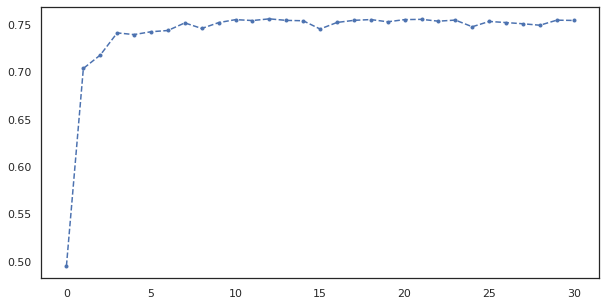

In [207]:
plt.subplots(figsize=[10, 5])
plt.plot(sgld_aux["accuracy"], "--.")
# plt.plot(sgld_aux["train_accuracy"], "--.")

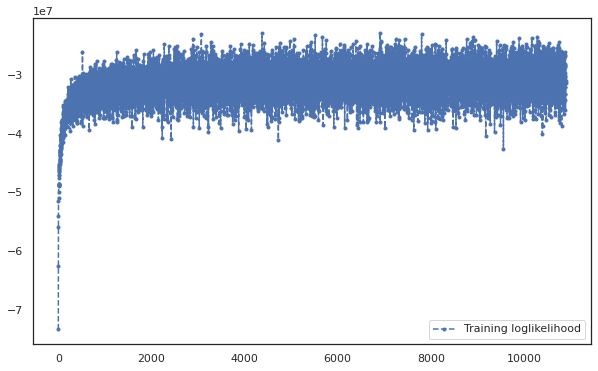

In [208]:
spaced_idx = np.arange(0, NUM_STEPS, NUM_STEPS // NUM_VALS)

# Test loglikelihood
plt.subplots(figsize=[10, 6])
plt.plot(sgld_aux["training_logp"], "--.", label="Training loglikelihood")
# plt.plot(spaced_idx, sgld_aux["test_logp"], "--.", label="Test loglikelihood")
plt.legend()

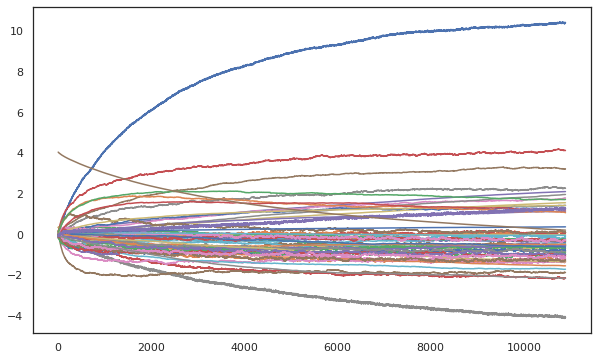

In [209]:
plt.subplots(figsize=[10, 6])
plt.plot(sgld_aux["training_mean"]);
# l = plt.ylim()

# SGLD Sweep

In [210]:
key, subkey = random.split(key)

def sgld_acc(lr):
    particles = run_sgld(subkey, init_batch, lr)
    acc = particles.rundata["accuracy"]
    return np.mean(np.array(acc[-10:]))

def print_accs(lrs, accs):
    accs = np.asarray(accs)
    plt.plot(lrs, accs, "--.")
    plt.xscale("log")

In [ ]:
accs_sweep = []
lrs = np.logspace(-9, -4, 15)
for lr in lrs:
    accs_sweep.append(sgld_acc(lr))
print_accs(lrs, accs_sweep)

10894it [00:18, 593.92it/s]                           
10894it [00:18, 593.20it/s]                           
10894it [00:17, 623.54it/s]                           
10894it [00:17, 610.55it/s]                           
10894it [00:17, 626.28it/s]                           
10894it [00:18, 603.17it/s]                           
10894it [00:18, 590.90it/s]                           
10894it [00:18, 577.95it/s]                           
10894it [00:23, 469.26it/s]                           
10894it [00:23, 466.05it/s]                           
10894it [00:23, 465.90it/s]                           
  0%|          | 1/10893 [00:01<5:55:55,  1.96s/it]

In [ ]:
accs_sweep = []
lrs = np.logspace(-6, 1, 15)
for lr in lrs:
    accs_sweep.append(sgld_acc(lr))
print_accs(lrs, accs_sweep)

In [ ]:
lrs[np.array(accs_sweep).argmax()]

# calibration curve

In [ ]:
@jit
def batch_probs(w):
    """Returns test probabilities P(y=1) for
    all y in the test set, for w a parameter array
    of shape (n, num_features)"""
    probs = vmap(lambda wi: compute_probs(y_test, x_test, wi))(w)
    return np.mean(probs, axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=[5, 5])

probs = batch_probs(w_samples)
true_freqs, bins = calibration_curve(y_test, probs, n_bins=10)
ax.plot(true_freqs, bins, "--o")
#     print(bins)
ax.plot(bins, bins)
ax.set_ylabel("True frequency")
ax.set_xlabel("Predicted probability")
ax.set_title("SGLD Calibration")

# Try with TFP

In [ ]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [ ]:
# bs = 10**5
# nb = num_datapoints // bs # num batches
# tfp_batches = get_batches(x_train, y_train, n_steps=10, batch_size=bs)
# nb

In [ ]:
# xx, yy = next(tfp_batches)
xx, yy = x_train, y_train
def target_log_prob(params):
    return get_minibatch_logp(x_train, y_train)(params)

In [ ]:
# kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=target_log_prob, step_size=1e-2)
# kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob_fn=target_log_prob, step_size=1e-5)

@jit
def run_chain(key, state):
    return tfp.mcmc.sample_chain(500,
      current_state=state,
      kernel=kernel,
      trace_fn = None,
      num_burnin_steps=0,
      seed=key)

In [ ]:
m = 100
key, subkey = random.split(key)
init_batch = sample_from_prior(subkey, m)
init_batch = ravel(*init_batch)

In [ ]:
key, subkey = random.split(key)
vstates = vmap(run_chain)(random.split(subkey, m), init_batch)

In [ ]:
tfp_samples = vstates[-1]
print(np.mean(np.isnan(tfp_samples)))
compute_test_accuracy(unravel(tfp_samples)[0])

In [ ]:
tfp_samples.shape

In [ ]:
unravel(tfp_samples)[0].shape

In [ ]:
@jit
def tfp_accuracy(l.ipynb_checkpoints/, key):
    kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob_fn=target_log_prob, step_size=lr)

    def run_chain(rngkey, state):
        return tfp.mcmc.sample_chain(500,
          current_state=state,
          kernel=kernel,
          trace_fn = None,
          num_burnin_steps=0,
          seed=rngkey)

    key, subkey = random.split(key)
    m = 100
    key, subkey = random.split(key)
    init_batch = sample_from_prior(subkey, m)
    init_batch = ravel(*init_batch)
    vstates = vmap(run_chain)(random.split(subkey, m), init_batch)
    return compute_test_accuracy(unravel(vstates[-1])[0])

In [ ]:
tfp_accs_sweep = []
lrs = np.logspace(-8, -2, 10)
for lr in tqdm(lrs):
    tfp_accs_sweep.append(tfp_accuracy(lr, subkey))
print_accs(lrs, tfp_accs_sweep)

In [ ]:
lrs[np.array(tfp_accs_sweep).argmax()]